C:\Users\Ankitha\AppData\Local\Temp\ipykernel_4500\2823654235.py:12: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('train.csv')


Data loaded and merged successfully.
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861

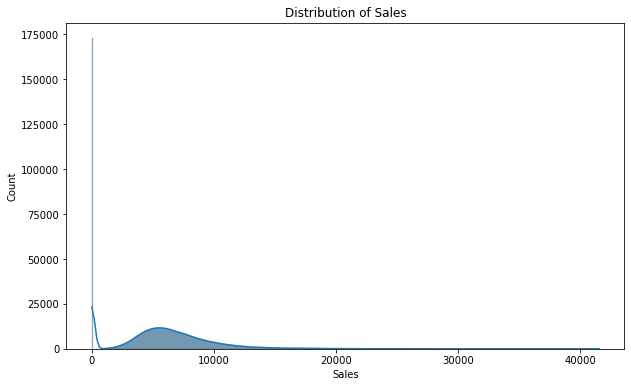

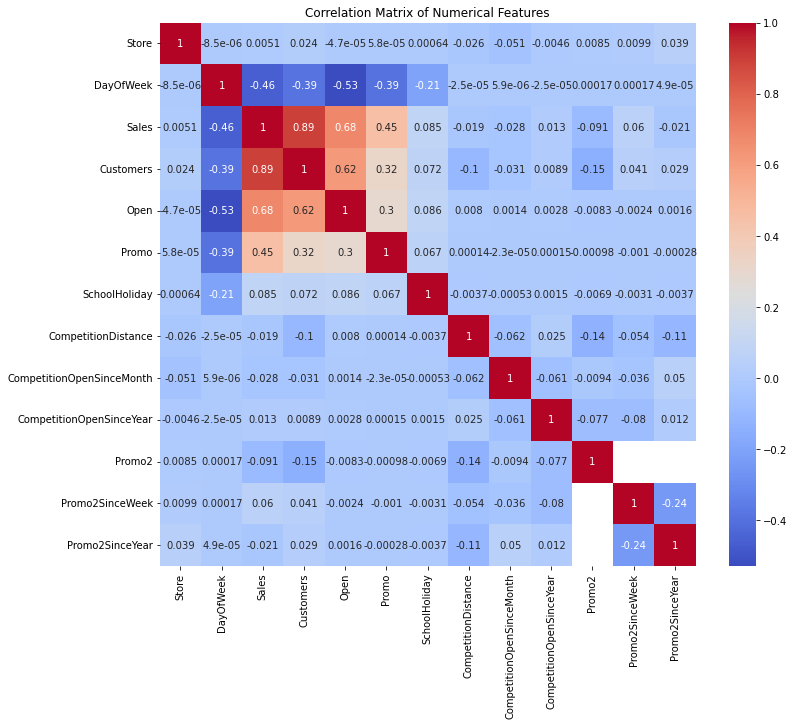

Data preprocessing completed.
Mean Squared Error: 728876.0187213318
Mean Absolute Error: 492.72296978991557
R-squared Score: 0.9507143103300328


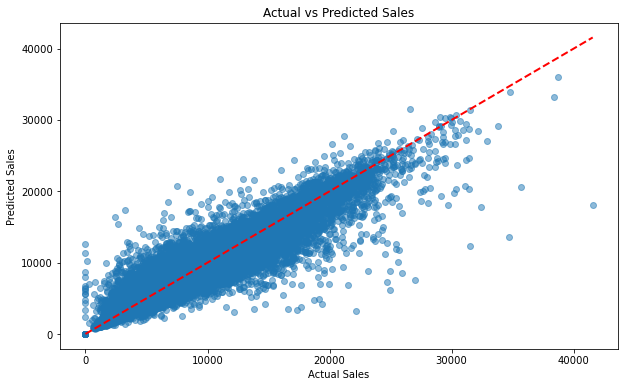

Predictions made and saved to 'submission.csv'


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
store = pd.read_csv('store.csv')


train = pd.merge(train, store, on='Store', how='left')

print("Data loaded and merged successfully.")

print(train.info())
print(train.describe())


print(train.isnull().sum())


plt.figure(figsize=(10, 6))
sns.histplot(train['Sales'], kde=True)
plt.title('Distribution of Sales')
plt.show()


correlation_matrix = train.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()


train['Date'] = pd.to_datetime(train['Date'])
train['Year'] = train['Date'].dt.year
train['Month'] = train['Date'].dt.month
train['Day'] = train['Date'].dt.day
train['DayOfWeek'] = train['Date'].dt.dayofweek


train['StateHoliday'] = train['StateHoliday'].map({'0':0, 'a':1, 'b':2, 'c':3, 0:0})
train = pd.get_dummies(train, columns=['StoreType', 'Assortment', 'PromoInterval'])


features = ['Store', 'DayOfWeek', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
            'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
            'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'Year', 'Month', 'Day',
            'StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d',
            'Assortment_a', 'Assortment_b', 'Assortment_c',
            'PromoInterval_Feb,May,Aug,Nov', 'PromoInterval_Jan,Apr,Jul,Oct', 'PromoInterval_Mar,Jun,Sept,Dec']

X = train[features]
y = train['Sales']


imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

print("Data preprocessing completed.")

X_train, X_val, y_train, y_val = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)


y_pred = rf_model.predict(X_val_scaled)


mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared Score: {r2}")


plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Actual vs Predicted Sales")
plt.show()


test = pd.merge(test, store, on='Store', how='left')

test['Date'] = pd.to_datetime(test['Date'])
test['Year'] = test['Date'].dt.year
test['Month'] = test['Date'].dt.month
test['Day'] = test['Date'].dt.day
test['DayOfWeek'] = test['Date'].dt.dayofweek

test['StateHoliday'] = test['StateHoliday'].map({'0':0, 'a':1, 'b':2, 'c':3, 0:0})
test = pd.get_dummies(test, columns=['StoreType', 'Assortment', 'PromoInterval'])


missing_cols = set(train.columns) - set(test.columns)
for c in missing_cols:
    if 'StoreType_' in c or 'Assortment_' in c or 'PromoInterval_' in c:
        test[c] = 0


X_test = test[features]


X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)


X_test_scaled = scaler.transform(X_test_imputed)

test_predictions = rf_model.predict(X_test_scaled)


submission = pd.DataFrame({
    'Id': test['Id'],
    'Sales': test_predictions
})
submission.to_csv('submission.csv', index=False)

print("Predictions made and saved to 'submission.csv'")


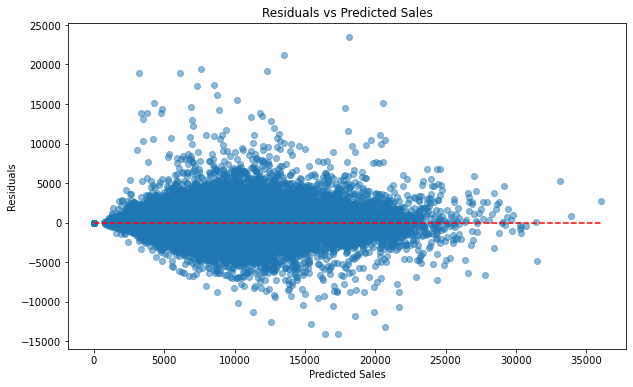

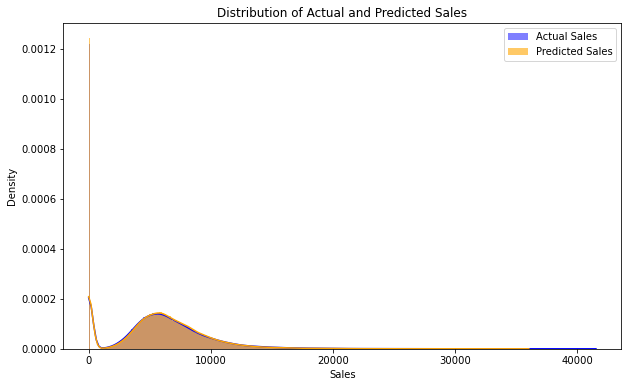

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns


# Residual plot
residuals = y_val - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.hlines(0, xmin=y_pred.min(), xmax=y_pred.max(), colors='r', linestyles='dashed')
plt.xlabel('Predicted Sales')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Sales')
plt.show()

# Distribution plot: Actual vs Predicted
plt.figure(figsize=(10, 6))
sns.histplot(y_val, color='blue', label='Actual Sales', kde=True, stat='density', linewidth=0)
sns.histplot(y_pred, color='orange', label='Predicted Sales', kde=True, stat='density', linewidth=0, alpha=0.6)
plt.xlabel('Sales')
plt.title('Distribution of Actual and Predicted Sales')
plt.legend()
plt.show()

